In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd

Using cuda device
/home/mag/predictive-coding-thesis/src


In [3]:
torch.manual_seed(321)

# This appears to converge to a gray square with 
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])

data_dir = 'data/face-north'
target_dir_name = 'frames'

dataset = AutoencoderDataset(source_directory=data_dir, 
                                 transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{len(train_data)} training samples')

batch_size = 10
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

72000 training samples


In [3]:
latent_model_file = 'model_files/faceforward_noisy_83143_samples-200ep-causal.pt'
latent_model = PredictiveCoderWithHead()
latent_model.to(device)
latent_model.load_state_dict(torch.load(latent_model_file))#, map_location=torch.device(device)))
latent_model.eval()
for param in latent_model.parameters():
    param.requires_grad = False
    

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#seq, corr = next(iter(train_loader))
img = next(iter(train_loader)) 

#print(seq[0].shape)
#print(seq[1].shape)

#headings = torch.unsqueeze(seq[1][0], 0)
#seq = torch.unsqueeze(seq[0][0], 0)

#imshow(torchvision.utils.make_grid(seq[0][0]))
#imshow(corr[0])
imshow(img[0])

with torch.no_grad():
    pred = latent_model(img.to(device))
    #pred = latent_model(seq.to(device), headings.to(device)) 

imshow(pred[0])


### Testing the spatial maps

In [6]:
data = np.load('data/face-forward/coords_random_faceforward_2024-01-09-17-09-17.npy')

print(np.max(data[:,0]))
print(np.min(data[:,0]))
print(np.max(data[:,1]))
print(np.min(data[:,1]))

-424.5
-487.5
-654.5
-692.5


In [4]:
from torch.utils.data._utils.collate import default_collate

def normalize_coords(batch):
    """
    Custom collate function that normalizes the target values in a batch.
    Assumes each element in batch is a tuple (features, target) and target is a tensor of shape (2,)
    with target[0] as x and target[1] as y.
    """

    # Separate features and targets
    features, targets = zip(*batch)

    # Convert lists to PyTorch tensors using default collate
    features = default_collate(features)
    targets = default_collate(targets)

    # Normalize targets
    x_min, x_max = -487.5, -424.5
    y_min, y_max = -692.5, -654.5

    targets[..., 0] = (targets[..., 0] - x_min) / (x_max - x_min)  # Normalize x
    targets[..., 1] = (targets[..., 1] - y_min) / (y_max - y_min)  # Normalize y

    return features, targets[:, :-1]

def normalize_yaw(batch):
    features, targets = zip(*batch)

    features = default_collate(features)
    targets = default_collate(targets)

    yaw_min, yaw_max = 0, 285 # for some reason, need to fix

    yaw = (targets[..., 2] - yaw_min) / (yaw_max - yaw_min)

    return features, yaw.unsqueeze(1)

In [5]:
# Load in the coordinate data
data_dir = 'data/noisy'

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])

dataset = CoordinateDataset(source_directory=data_dir, transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=normalize_yaw)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=normalize_yaw)

['coords_random_faceforward_2024-02-22-16-55-17.npy', 'coords_random_faceforward_2024-02-22-16-55-45.npy', 'coords_random_faceforward_2024-02-22-16-55-58.npy', 'coords_random_faceforward_2024-02-22-17-16-09.npy', 'coords_random_faceforward_2024-02-22-17-19-15.npy', 'coords_random_faceforward_2024-02-22-17-29-38.npy', 'coords_random_faceforward_2024-02-22-17-36-21.npy', 'coords_random_faceforward_2024-02-22-21-00-56.npy', 'coords_random_faceforward_2024-02-22-21-14-48.npy']
97200 training samples


In [18]:
def denormalize_targets(normalized_target):
    """
    Denormalizes the target values from the range [0, 1] back to their original scale.
    Assumes normalized_target is a tensor of shape (..., 2) where normalized_target[..., 0] is x and normalized_target[..., 1] is y.
    """
    # Define the min and max values for x and y
    x_min, x_max = -487.5, -424.5
    y_min, y_max = -692.5, -654.5

    # Denormalize x
    x_denormalized = normalized_target[..., 0] * (x_max - x_min) + x_min
    
    # Denormalize y
    y_denormalized = normalized_target[..., 1] * (y_max - y_min) + y_min

    # Combine and return
    return torch.stack([x_denormalized, y_denormalized], dim=-1)

def denormalize_yaws(normalized_target):
    yaw_min, yaw_max = 0, 285

    return torch.stack([normalized_target[..., 0] * (yaw_max - yaw_min) + yaw_min], dim=-1)

In [7]:
# Sample of coord dataset:

x, y = next(iter(test_loader))
print(x.shape, y.shape)

print(y[0])

torch.Size([16, 3, 64, 64]) torch.Size([16, 1])
tensor([0.6351])


In [6]:
# Set up the model, which takes as input my trained predictive coder encoder and attn
device = 'cuda:1' if torch.cuda.is_available() else "cpu"

model = HeadDirectionPredictor(latent_model, input_dim=128, hidden_dim=200)
model.to(device)

num_epochs = 5
steps_per_epoch = len(train_loader)

learning_rate = 0.01
weight_decay = 0.0001

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)


In [11]:
from torch.autograd import profiler

x = x.to(device)
print(x.shape)

with profiler.profile(use_cuda=torch.cuda.is_available()) as prof:
    with profiler.record_function("model_inference"):
        model(x)

print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total"))


torch.Size([128, 3, 64, 64])
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  model_inference        31.12%       4.675ms        99.90%      15.008ms      15.008ms       4.155ms        27.67%      15.017ms      15.017ms             1  
                                 aten::batch_norm         2.36%     354.000us        28.90%       4.341ms     228.474us     346.000us         2.30%       4.466ms     235.053us            19  
          

STAGE:2024-02-17 20:18:15 2685585:2685585 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-17 20:18:15 2685585:2685585 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-17 20:18:15 2685585:2685585 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [8]:
train_losses_file = 'logs/faceforward_noisy_83143_samples-200ep-causal-headdir-predict-train.txt'
test_losses_file = 'logs/faceforward_noisy_83143_samples-200ep-causal-headdir-predict-train.txt'
loc_predictor_file = 'model_files/faceforward_noisy_83143_samples-200ep-causal-headdir-predict.pt'

train_losses = []
test_losses = []
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, device)
        test_loss = test(test_loader, model, loss_fn, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        torch.save(model.state_dict(), loc_predictor_file)

finally:
    torch.save(model.state_dict(), loc_predictor_file)
    
    with open(train_losses_file, 'w') as fp:
        for s in train_losses:
            fp.write("%s\n" % s)
            
    with open(test_losses_file, 'w') as fp:
        for x in test_losses:
            fp.write("%s\n" % x)
    
    print("Done!")


# need to write something to see if every view is being considered (altho it's the same test set, you're trying to see if it can do this regardless of context right?
# also, need to see if the location is better if it goes through self attention first???

Epoch 1
-------------------------------
loss: 0.557607  [    0/97200]
loss: 0.069333  [16000/97200]
loss: 0.068901  [32000/97200]
loss: 0.087441  [48000/97200]
loss: 0.033985  [64000/97200]
loss: 0.027335  [80000/97200]
loss: 0.042314  [96000/97200]
Test Error: 
 Avg loss: 0.043413 

Epoch 2
-------------------------------
loss: 0.022866  [    0/97200]
loss: 0.017646  [16000/97200]
loss: 0.059914  [32000/97200]
loss: 0.036197  [48000/97200]
loss: 0.035391  [64000/97200]
loss: 0.049958  [80000/97200]
loss: 0.036408  [96000/97200]
Test Error: 
 Avg loss: 0.032986 

Epoch 3
-------------------------------
loss: 0.035736  [    0/97200]
loss: 0.032328  [16000/97200]
loss: 0.030719  [32000/97200]
loss: 0.022489  [48000/97200]
loss: 0.047047  [64000/97200]
loss: 0.043440  [80000/97200]
loss: 0.026156  [96000/97200]
Test Error: 
 Avg loss: 0.028304 

Epoch 4
-------------------------------
loss: 0.048546  [    0/97200]
loss: 0.028581  [16000/97200]
loss: 0.034929  [32000/97200]
loss: 0.020338 

In [10]:
latent_model_file = 'model_files/faceforward_noisy_83143_samples-200ep-causal.pt'
latent_model = PredictiveCoderWithHead()
latent_model.to(device)
latent_model.load_state_dict(torch.load(latent_model_file))#, map_location=torch.device(device)))
latent_model.eval()
for param in latent_model.parameters():
    param.requires_grad = False

model_file = 'model_files/faceforward_noisy_83143_samples-200ep-causal-headdir-predict.pt'

model = HeadDirectionPredictor(latent_model, hidden_dim=200)
model.load_state_dict(torch.load(model_file))
model.to(device)
model.eval()

HeadDirectionPredictor(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [21]:
## Visualize predicted head direction
from collections import defaultdict

model.eval()
for param in model.parameters():
    param.requires_grad = False

predictions_sum = defaultdict(lambda: [torch.zeros(1), 0])

with torch.no_grad():
    for frames, actual_yaws in test_loader:
        frames, actual_yaws = frames.to(device), actual_yaws.to(device)
        predictions = model(frames)
        #print(predictions.shape)
        #print(actual_yaws.shape)
        for actual, pred in zip(actual_yaws, predictions):
            denorm_actual = denormalize_yaws(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count

    for frames, actual_yaws in train_loader:
        frames, actual_locations = frames.to(device), actual_yaws.to(device)
        predictions = model(frames)

        for actual, pred in zip(actual_yaws, predictions):
            denorm_actual = denormalize_yaws(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count
            
# Calculate the average predicted yaw for each actual yaw
average_predictions = {actual: denormalize_yaws(sum_pred[0] / sum_pred[1]) for actual, sum_pred in predictions_sum.items()}

# Example: Print the average predicted yaw for each actual yaw
for actual_location, average_pred in average_predictions.items():
    print(f"Actual Yaw: {actual_location}, Average Predicted Yaw: {average_pred.numpy()}")


Actual Yaw: (10.0,), Average Predicted Yaw: [25.179483]
Actual Yaw: (11.0,), Average Predicted Yaw: [29.612137]
Actual Yaw: (275.0,), Average Predicted Yaw: [275.56564]
Actual Yaw: (97.0,), Average Predicted Yaw: [99.98641]
Actual Yaw: (185.00002,), Average Predicted Yaw: [175.92447]
Actual Yaw: (9.0,), Average Predicted Yaw: [23.962976]
Actual Yaw: (91.0,), Average Predicted Yaw: [98.55483]
Actual Yaw: (272.0,), Average Predicted Yaw: [272.37704]
Actual Yaw: (281.0,), Average Predicted Yaw: [281.54242]
Actual Yaw: (191.0,), Average Predicted Yaw: [178.64117]
Actual Yaw: (193.0,), Average Predicted Yaw: [178.37111]
Actual Yaw: (188.0,), Average Predicted Yaw: [177.22273]
Actual Yaw: (186.0,), Average Predicted Yaw: [176.65588]
Actual Yaw: (279.0,), Average Predicted Yaw: [279.85492]
Actual Yaw: (282.0,), Average Predicted Yaw: [278.714]
Actual Yaw: (94.0,), Average Predicted Yaw: [97.25738]
Actual Yaw: (15.0,), Average Predicted Yaw: [36.324818]
Actual Yaw: (7.0,), Average Predicted Ya

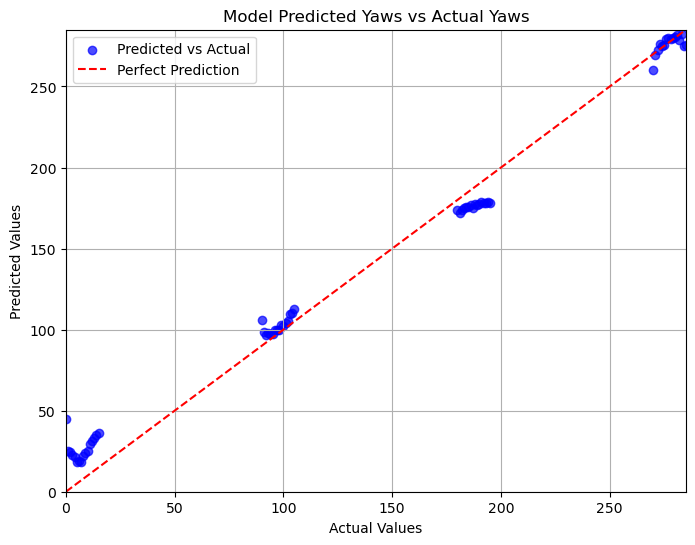

In [22]:

plt.figure(figsize=(8, 6))
plt.scatter(average_predictions.keys(), average_predictions.values(), alpha=0.7, color='blue', label='Predicted vs Actual')
plt.title('Model Predicted Yaws vs Actual Yaws')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([0, 285], [0, 285], 'r--', label='Perfect Prediction')  # Red dashed line for perfect prediction
plt.xlim([0, 285])
plt.ylim([0, 285])
plt.legend()
plt.grid(True)
plt.show()

In [17]:
x, y = next(iter(train_loader))

model.eval()
with torch.no_grad():
    pred = model(x.to(device))

print(denormalize_targets(pred[:10]))
print(denormalize_targets(y[:10]))

tensor([[-447.5521, -661.1363],
        [-429.2477, -665.6050],
        [-457.8824, -689.8747],
        [-458.4578, -657.0142],
        [-433.7978, -669.3201],
        [-478.8492, -669.2361],
        [-433.5062, -676.2069],
        [-469.8455, -668.2211],
        [-460.5239, -684.4845],
        [-486.0485, -673.8364]], device='cuda:1')
tensor([[-455.5000, -662.5000],
        [-424.5000, -663.5000],
        [-456.5000, -689.5000],
        [-465.5000, -654.5000],
        [-424.5000, -668.5000],
        [-477.5000, -658.5000],
        [-432.5000, -678.5000],
        [-472.5000, -667.5000],
        [-466.5000, -686.5000],
        [-487.5000, -690.5000]])


In [ ]:
import torch
from collections import defaultdict

model.eval()  # Set the model to evaluation mode

# Dictionary to store sum of predictions and count for each actual location
predictions_sum = defaultdict(lambda: [torch.zeros(2), 0])

with torch.no_grad():  # Disable gradient computation
    for frames, actual_locations in test_loader:
        frames, actual_locations = frames.to(device), actual_locations.to(device)
        # Pass the features through the model to get predictions
        predictions = model(frames)

        # Iterate through the batch and update the predictions_sum dictionary
        for actual, pred in zip(actual_locations, predictions):
            denorm_actual = denormalize_targets(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count

    for frames, actual_locations in train_loader:
        frames, actual_locations = frames.to(device), actual_locations.to(device)
        # Pass the features through the model to get predictions
        predictions = model(frames)

        # Iterate through the batch and update the predictions_sum dictionary
        for actual, pred in zip(actual_locations, predictions):
            denorm_actual = denormalize_targets(actual.cpu())
            actual = tuple(denorm_actual.numpy())  # Convert to a tuple for dictionary key
            predictions_sum[actual][0] += pred.cpu()  # Sum of predictions
            predictions_sum[actual][1] += 1  # Count
            
# Calculate the average predicted location for each actual location
average_predictions = {actual: denormalize_targets(sum_pred[0] / sum_pred[1]) for actual, sum_pred in predictions_sum.items()}

# Example: Print the average predicted location for each actual location
for actual_location, average_pred in average_predictions.items():
    print(f"Actual Location: {actual_location}, Average Predicted Location: {average_pred.numpy()}")


In [19]:
import pickle 

f = open("logs/autoencoder_north_locs.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(average_predictions, f)

# close file
f.close()

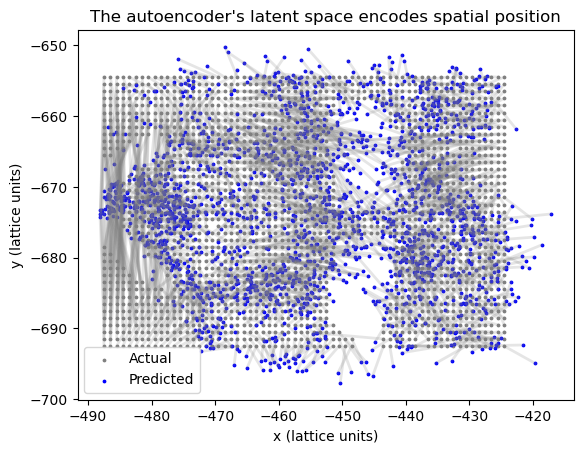

In [3]:
import matplotlib.pyplot as plt
import numpy as np

f = open("logs/autoencoder_north_locs.pkl", "rb")
average_predictions = pickle.load(f)

# Assuming we have two sets of data points, one for actual (ground truth) and one for predicted
# For demonstration, random points around a line y=x will be generated for actual
# and points with some added noise for predicted

np.random.seed(0) # for reproducibility

actual_x = np.array([pos[0] for pos in average_predictions.keys()])
actual_y = np.array([pos[1] for pos in average_predictions.keys()])

predicted_x = np.array([pos[0] for pos in average_predictions.values()])
predicted_y = np.array([pos[1] for pos in average_predictions.values()])

# Calculate errors (distance) between actual and predicted points
errors_x = predicted_x - actual_x
errors_y = predicted_y - actual_y
errors = np.sqrt(errors_x**2 + errors_y**2)

# Create the figure and the axis
fig, ax = plt.subplots()

# Plot actual points
ax.scatter(actual_x, actual_y, s=3, color='gray', label='Actual')

# Plot predicted points
ax.scatter(predicted_x, predicted_y, s=3, color='blue', label='Predicted')

# Plot error lines
for i in range(len(actual_x)):
    ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], color='gray', linewidth=2, alpha=0.2)

# Set labels and title
ax.set_xlabel('x (lattice units)')
ax.set_ylabel('y (lattice units)')
ax.set_title('The autoencoder\'s latent space encodes spatial position')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [40]:
# I actually think it's spreading them out maybe because with the outer points, there's not a lot of confusion

## Analyze the distance errors between baseline models  

In [4]:

# Make the predictive coding model (face north)
average_predictions_north = np.load('logs/north_locs.pkl', allow_pickle=True)
base_np = np.stack(list(average_predictions_north.keys()))
predictive_values = np.stack([pos for pos in average_predictions_north.values()], axis=0)
data_predictive_coding = np.linalg.norm(predictive_values - base_np, axis=1)

# Make the predictive coding model (facing forward)
average_predictions = np.load('logs/actual_locs_forward_2.pkl', allow_pickle=True)
base_np = np.stack(list(average_predictions.keys()))
predictive_values = np.stack([pos for pos in average_predictions.values()], axis=0)
data_predictive_coding_forward = np.linalg.norm(predictive_values - base_np, axis=1)

del average_predictions_north

# Make the predictive coding model (noisy)
average_predictions_noisy = np.load('logs/noisy-locs.pkl', allow_pickle=True)
base_np = np.stack(list(average_predictions_noisy.keys()))
predictive_values = np.stack([pos for pos in average_predictions_noisy.values()], axis=0)
data_predictive_coding_noisy = np.linalg.norm(predictive_values - base_np, axis=1)

del average_predictions_noisy

# Make the autoencoder model
autoencoder_locs = np.load('logs/autoencoder_north_locs.pkl', allow_pickle=True)
base_np = np.stack(list(autoencoder_locs.keys()))
autoencode_values = np.stack([pos for pos in autoencoder_locs.values()], axis=0)
data_auto_encoding = np.linalg.norm(autoencode_values - base_np, axis=1)

del autoencoder_locs
#del autoencoder_locs

# Make the shuffle model
shuffled = base_np.copy()
np.random.shuffle(shuffled)
print(shuffled.shape)
data_random_pairs = np.linalg.norm(shuffled - base_np, axis=1)

# Make the added noise model
std = 1
added_noise = []

for pos in average_predictions.keys():
    noise = np.random.normal(0, std)
    added_noise.append([pos[0] + noise, pos[1] + noise])

noisy_np = np.stack(added_noise, axis=0)
base_np = np.stack(list(average_predictions.keys()))
data_noise_model = np.linalg.norm(noisy_np - base_np, axis=1)

(2081, 2)


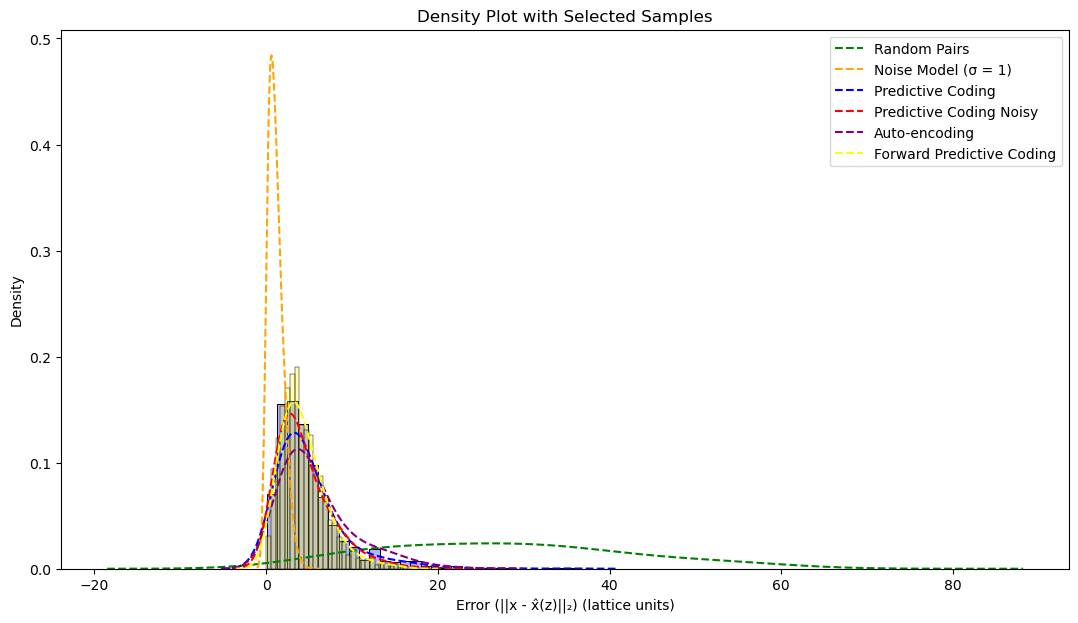

In [5]:
import seaborn as sns

plt.figure(figsize=(13, 7))

# Plotting KDE for all distributions
sns.kdeplot(data_random_pairs, bw_adjust=2, label="Random Pairs", color="green", linestyle="--")
sns.kdeplot(data_noise_model, bw_adjust=2, label="Noise Model (σ = 1)", color="orange", linestyle="--")
sns.kdeplot(data_predictive_coding, bw_adjust=2, label="Predictive Coding", color="blue", linestyle="--")
sns.kdeplot(data_predictive_coding_noisy, bw_adjust=2, label="Predictive Coding Noisy", color="red", linestyle="--")
sns.kdeplot(data_auto_encoding, bw_adjust=2, label="Auto-encoding", color="purple", linestyle="--")
sns.kdeplot(data_predictive_coding_forward, bw_adjust=2, label="Forward Predictive Coding", color="yellow", linestyle="--")

# Plotting histograms only for predictive coding and auto-encoding with normalization
sns.histplot(data_predictive_coding, kde=False, color="blue", alpha=0.3, bins=30, stat="density")
sns.histplot(data_predictive_coding_forward, kde=False, color="yellow", alpha=0.3, bins=30, stat="density")

# Additional plot formatting to match the user's request
plt.title('Density Plot with Selected Samples')
plt.xlabel('Error (||x - x̂(z)||₂) (lattice units)')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
# saccading can tell you about state of the internal cognitive map

# I mean one issue here is the forward pred coding might be improved just from the pred code because of the larger train set

# or some reason my autoencoder results are suddenly very poopy so I'm gonna try for 200 like the paper says